In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slopes_r_p_onlysub, slopes_r_p_mix, slope_time, slope_maps
import regression
#from coare_functions import *
import meteo
import lcl
import metpy.calc as mpcalc
from metpy.units import units


import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan

    
    
tourbillons_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy')
open_ocean_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy')


fourier_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_forced.npy')
fourier_large = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_forced_LARGE.npy')

In [3]:
# read  data
path_data = '/saturn/simu_Caribbean/forced_3km/CNT/FEB/01/'
wrf_files = path_data + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))
ds = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested')

In [4]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.
# select domain
mask_lon = (ds.XLONG >= minlon) & (ds.XLONG <= maxlon)
mask_lat = (ds.XLAT >= minlat) & (ds.XLAT <= maxlat)
ds = ds.where(mask_lon & mask_lat, drop=True)

In [5]:
# def lon lat time
lon = ds['XLONG'][0].values
lat = ds['XLAT'][0].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()
del seamask_nocoast, lakemask, landmask

In [7]:
# daily variables
sst_ff = ds['SST'].groupby('XTIME.day').mean()*seamask - 273.15 # °C
sst_ff = sst_ff.where(fourier_large, drop=False)*fourier_large; 
sst_spectr = sst_ff.values[~np.isnan(sst_ff.values)]
sst_spectr = sst_spectr.reshape(29, 250, 250)


ta_ff = ds['T2'].groupby('XTIME.day').mean()*seamask - 273.15 # °C
ta_ff = ta_ff.where(fourier_large, drop=False)*fourier_large; 
ta_spectr = ta_ff.values[~np.isnan(ta_ff.values)]
ta_spectr = ta_spectr.reshape(29, 250, 250)

# Dt_ff = sst_ff -  ta_ff

In [8]:
# daily variables
p0 = 101300.
qa_ff = ds['Q2'].groupby('XTIME.day').mean()*seamask
qa_ff = qa_ff.where(fourier_large, drop=False)*fourier_large; 
qa_spectr = qa_ff.values[~np.isnan(qa_ff.values)]
qa_spectr = qa_spectr.reshape(29, 250, 250)


qsat_spectr = meteo.qsat(ta_spectr,p0)

# RH_ff = qa_ff/qsat(ta_ff,p0)

In [9]:
# daily variables
u10 = ds['U10'].groupby('XTIME.day').mean().values*seamask
v10 = ds['V10'].groupby('XTIME.day').mean().values*seamask
U_ff = np.sqrt(u10**2 + v10**2)*seamask
del u10,v10

U_ff = U_ff*fourier_large
U_spectr = U_ff[~np.isnan(U_ff)]
U_spectr = U_spectr.reshape(29, 250, 250)

In [10]:
# hfx WRF
lhf_wrf = ds['LH'].groupby('XTIME.day').mean()*seamask
lhf_wrf = lhf_wrf.where(fourier_large, drop=False)*fourier_large; 
lhf_spectr = lhf_wrf.values[~np.isnan(lhf_wrf.values)]
lhf_spectr = lhf_spectr.reshape(29, 250, 250)


hfx_wrf = ds['HFX'].groupby('XTIME.day').mean()*seamask
hfx_wrf = hfx_wrf.where(fourier_large, drop=False)*fourier_large; 
hfx_spectr = hfx_wrf.values[~np.isnan(hfx_wrf.values)]
hfx_spectr = hfx_spectr.reshape(29, 250, 250)

In [11]:
def special_spectrum_1D(y):
    import numpy as np    
    
    if y.ndim == 1:
        ################
        # multiplying by 3 because the gridpoints are each separated by 3km
        lengths_loc = 3*np.arange(0,len(y))
        ################

        fourier = np.fft.fft(y, norm='ortho')/((y.size-1))
        
        # multiply by 2\pi to obtain wavenumbers
        wvnmr = (2*np.pi)*np.fft.fftfreq(lengths_loc.size, d=np.diff(lengths_loc)[0])

        return wvnmr, np.abs(fourier)
    else:
        print('y seems not to be 1D, check!')


def print_monthly_spectrum_1D(y, title, axis, distance=False):
    monthly_spectra_collector_lon = np.zeros((29, int(y[0,0].size), int(y[0,0].size)))
    monthly_spectra_collector_lat = np.zeros_like(monthly_spectra_collector_lon)
    wvnmr = np.zeros_like(monthly_spectra_collector_lon[0,0])

    for t in range(29):
        for i in range(y[t,0].size):
            yy = y[t, :, i] - np.nanmean(y[t, :, i])
            trash, monthly_spectra_collector_lon[t, i] = special_spectrum_1D(yy)

            yy = y[t, i, :] - np.nanmean(y[t, i, :])
            trash, monthly_spectra_collector_lat[t, i] = special_spectrum_1D(yy)

        if t == 1:
            # wvnmr are common for every spectrum, so I just save it once
            wvnmr = trash
            
    mean_monthly_spectrum_lon = np.mean(monthly_spectra_collector_lon, axis=(0,1))
    mean_monthly_spectrum_lat = np.mean(monthly_spectra_collector_lat, axis=(0,1))
    
    y_lon = mean_monthly_spectrum_lon[:mean_monthly_spectrum_lon.size//2]
    y_lat = mean_monthly_spectrum_lat[:mean_monthly_spectrum_lat.size//2]

    std_month_spectra_lon = np.std(monthly_spectra_collector_lon, axis=(0,1))   #/(np.sqrt(mean_spectrum.size))
    std_month_spectra_lat = np.std(monthly_spectra_collector_lat, axis=(0,1))   #/(np.sqrt(mean_spectrum.size))
    
    
    if distance:
        axis.loglog(2*np.pi/wvnmr[:wvnmr.size//2], y_lon, '.-', label='long')
        axis.loglog(2*np.pi/wvnmr[:wvnmr.size//2], y_lat, '.-', label='lat')
        axis.set_ylim([10e-6, 10e0])
        axis.set_xlabel(r'scales [$km$]', fontsize=14)
        
    else:
        axis.loglog(wvnmr[:wvnmr.size//2], y_lon, '.-', label='long')
        axis.loglog(wvnmr[:wvnmr.size//2], y_lat, '.-', label='lat')
        axis.set_ylim([10e-6, 10e0])
        axis.set_xlabel(r'wavenumber [$km^{-1}$]', fontsize=14)
    
    axis.set_ylabel('mean power spectrum  ( |coefficients| )', fontsize=14)
    axis.set_title('monthly mean 1D spectra of '+title, fontsize=14)
    axis.legend()
    
    return wvnmr, monthly_spectra_collector_lon, monthly_spectra_collector_lat

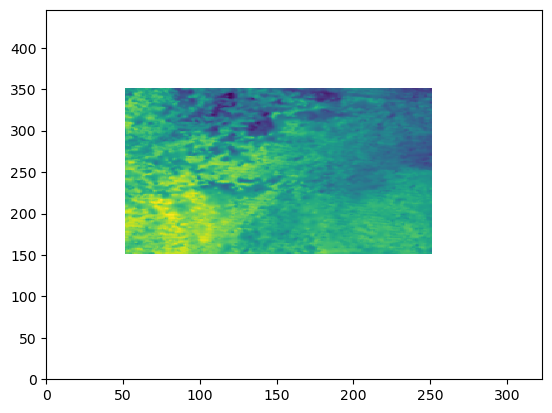

In [12]:
plt.pcolormesh(sst_ff[0])

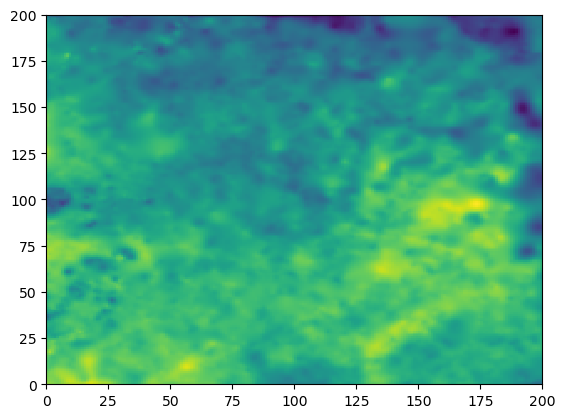

In [13]:
# sst_spectr = sst_day[~np.isnan(sst_day)]
# sst_spectr = sst_spectr.reshape(29, 273, 273)

plt.pcolormesh(sst_spectr[10])

Text(0.5, 1.0, '1D variations of SST within the Fourier domain')

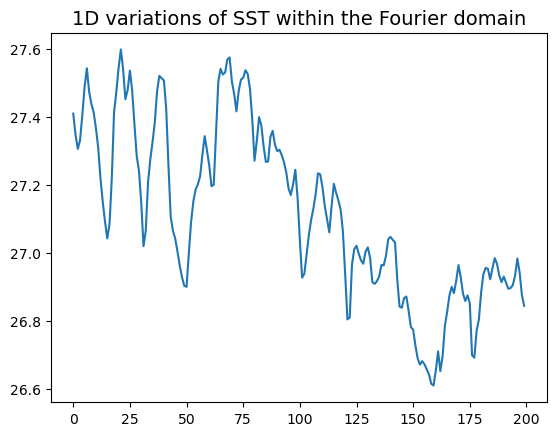

In [14]:
plt.plot(sst_spectr[0, 100])
plt.title('1D variations of SST within the Fourier domain', fontsize=14)


## there seem to be stronger oscillations and larger magnitudes of variations in this SSt compared to the coupled

# Computing spectra from here on

In [11]:
full_fields = {'SST':sst_spectr, 'T2': ta_spectr, 'qsat': qsat_spectr, 'q2': qa_spectr, 'U':U_spectr, 'LHF':lhf_spectr, 'HFX':hfx_spectr}

In [12]:
def power_spectrum_2d(c, dx, dy):
    # for the moment this func cannot deal with nan
    # c is input signal
    # dx is sampling rate along x
    # dy is sampling rate along y
    kx = np.fft.fftshift(np.fft.fftfreq(c.shape[1],dx))
    ky = np.fft.fftshift(np.fft.fftfreq(c.shape[0],dy))
    ps2 = np.abs(np.fft.fft2(c-np.mean(c), norm='ortho'))**2
    
    # shift to put freq 0 in the middle (positive freq up/right - negative freq bot/left)
    ps2 = np.fft.fftshift(ps2)   
    
    #ps2 = ps2/(len(kx)*len(ky))

    kkx,kky = np.meshgrid(kx,ky)
    distance = np.sqrt(kkx**2+kky**2)
    kmax = min(kx[-1],ky[-1])
    dk = kx[1]-kx[0]
    kloop = np.arange(dk,kmax+dk,dk)
    ps2_iso = np.zeros(len(kloop))
    
    for ik,k in enumerate(kloop):
        id_k = (distance>k)&(distance<k+dk)
        ps2_iso[ik] = np.nanmean(ps2[id_k])
    return kloop, ps2_iso

In [41]:
sigmas = [5, 20, 75, 150, 'inf']
sigmas_lab = [str(3*x) for x in sigmas[:-1]];  sigmas_lab.append('inf')

dictio_anomalies = {}

var_lab = 'HFX'
full_var = full_fields[var_lab]

for i, s in enumerate(sigmas):
    var_prime = np.zeros_like(full_var)
    
    for t in range(0, full_var.shape[0]):
        bar = gm.nan_gaussian_filter(full_var[t], s)
        var_prime[t] = full_var[t] - bar
    
    dictio_anomalies[sigmas_lab[i]] = var_prime
    print(f"sigma = {s}  DONE")


sigma = 5  DONE
sigma = 20  DONE
sigma = 75  DONE
sigma = 150  DONE
sigma = inf  DONE


In [42]:
fou_results = {}
dx, dy = 3, 3

for i, s in enumerate(sigmas):
    accu = np.zeros((full_var.shape[0], full_var.shape[1]//2))
    
    for t in range(full_var.shape[0]):
        k, accu[t] = power_spectrum_2d(dictio_anomalies[sigmas_lab[i]][t], dx, dy)
    
    accu = np.mean(accu, axis=0)
    fou_results[sigmas_lab[i]] = accu

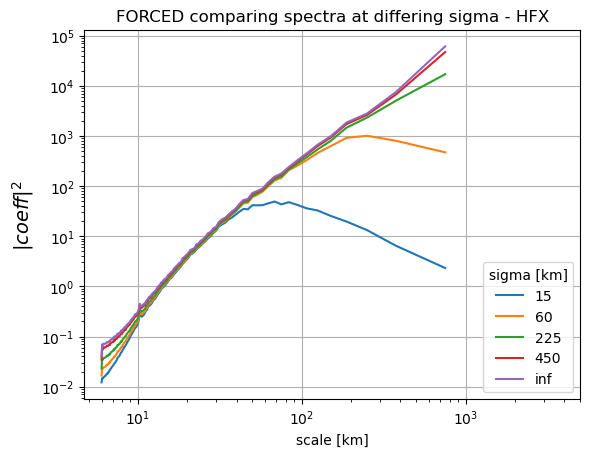

In [43]:
distances=True
x = 1/k if distances else k    # 2*np.pi/k
lower_limit, upper_limit = 0, 5000;
valid = (1/k > lower_limit) & (1/k < upper_limit)  # select only above 40km
xlab = "scale [km]" if distances else "$\lambda^{-1}$ [$km^{-1}$]"

tit = 'FORCED comparing spectra at differing sigma'+f" - {var_lab}"


for num, key in enumerate(fou_results):
    plt.loglog(x[valid], fou_results[key][valid], label=sigmas_lab[num])


plt.title(tit)
plt.xlabel(xlab)
plt.ylabel('$|coeff|^2$', fontsize=14)
plt.grid('both')
plt.legend(title='sigma [km]', loc='lower right')
plt.xlim([lower_limit-5, upper_limit+10])
plt.show()

In [ ]:
dictionary_to_be_saved = fou_results.copy()
# dictionary_to_be_saved['F(sum)'] = fou_of_sum
dictionary_to_be_saved['k'] = k

dictionary_to_be_saved['description'] = 'COUPLED model Fourier spectra of ' + var_lab + ' depending on the filter cutoff in the fourier_1 mask'


import pickle 

filename = 'coupled_' + var_lab + '_sigmaDependent_spectra.pkl'

with open('/venus/tesi_ale/data_EU/Fourier_spectra/coupled/sigmaDep/'+filename, 'wb') as f:
    pickle.dump(dictionary_to_be_saved, f)

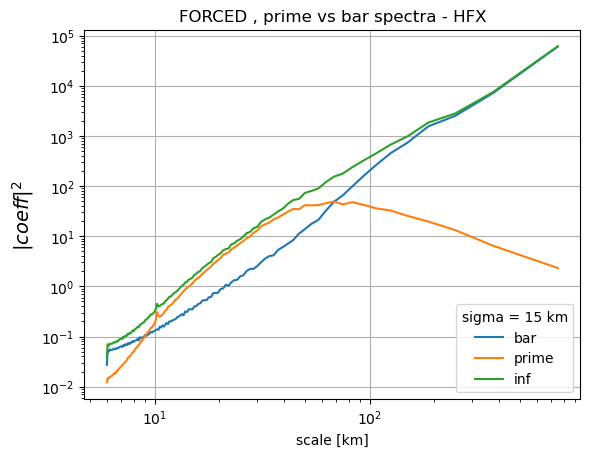

In [44]:
var_bar = np.zeros_like(full_var)

s_local = 5

for t in range(0, full_var.shape[0]):
    var_bar[t] = gm.nan_gaussian_filter(full_var[t], s_local)
    var_prime[t] = full_var[t] - var_bar[t]
        
fou_bar = np.zeros((full_var.shape[0], full_var.shape[1]//2))
fou_prime = np.zeros((full_var.shape[0], full_var.shape[1]//2))
    
for t in range(full_var.shape[0]):
    k, fou_bar[t] = power_spectrum_2d(var_bar[t], dx, dy)
    k, fou_prime[t] = power_spectrum_2d(var_prime[t], dx, dy)

fou_bar, fou_prime = np.mean(fou_bar, axis=0), np.mean(fou_prime, axis=0)






distances=True
x = 1/k if distances else k    # 2*np.pi/k
lower_limit, upper_limit = 0, 5000;
valid = (1/k > lower_limit) & (1/k < upper_limit)  # select only above 40km
xlab = "scale [km]" if distances else "$\lambda^{-1}$ [$km^{-1}$]"

tit = 'FORCED , prime vs bar spectra' + f" - {var_lab}"

plt.loglog(x[valid], fou_bar[valid],            label='bar')
plt.loglog(x[valid], fou_prime[valid],          label='prime')
plt.loglog(x[valid], fou_results['inf'][valid],   label='inf')


plt.title(tit)
plt.xlabel(xlab)
plt.ylabel('$|coeff|^2$', fontsize=14)
plt.grid('both')
plt.legend(title=f'sigma = {dx*s_local} km', loc='lower right')
# plt.xlim([lower_limit-5, upper_limit+10])
plt.show()

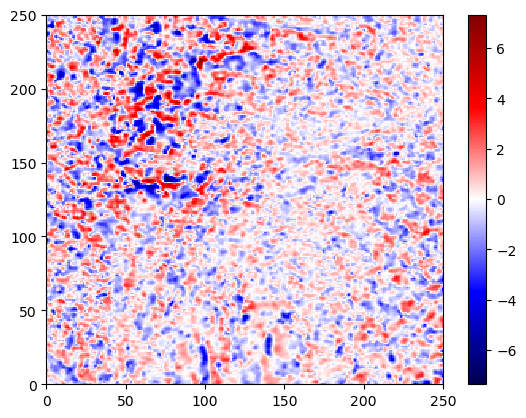

In [45]:
plt.pcolormesh(var_prime[0], cmap='seismic')
plt.colorbar()

### SST

(1e-06, 0.01)

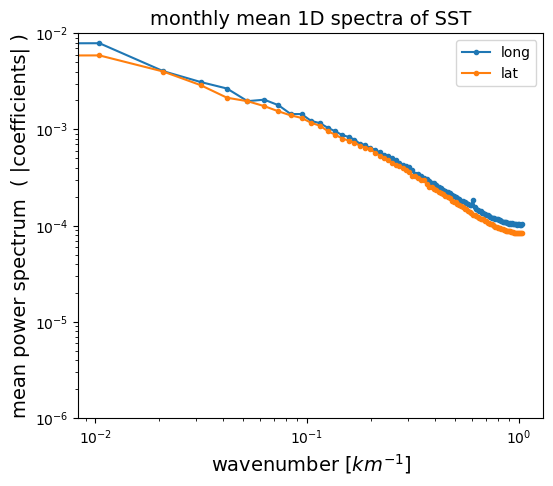

In [16]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

wvnmr, sst_month_lon, sst_month_lat = print_monthly_spectrum_1D(sst_spectr, title='SST', axis=ax, distance=False)
ax.set_ylim([10e-7, 10e-3])

### $T_{2m}$

(1e-06, 0.1)

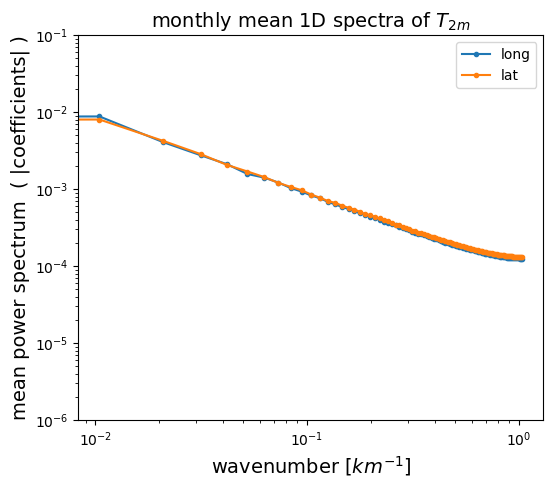

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

wvnmr, ta_month_lon, ta_month_lat = print_monthly_spectrum_1D(ta_spectr, title=r'$T_{2m}$', axis=ax, distance=False)
ax.set_ylim([10e-7, 10e-2])

### $q^*_{SST}$

(0.0001, 0.1)

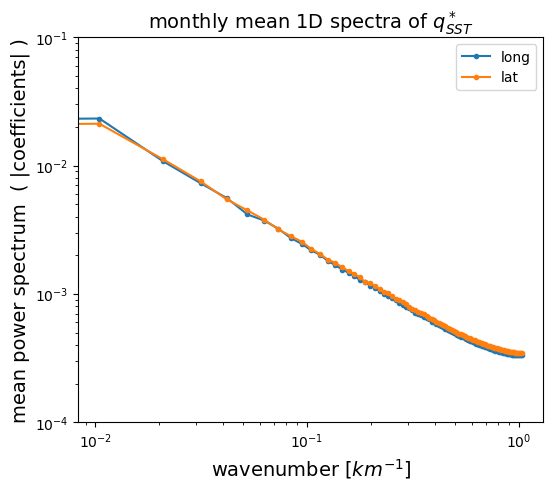

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

wvnmr, qsat_month_lon, qsat_month_lat = print_monthly_spectrum_1D(qsat_spectr, title='$q^*_{SST}$', axis=ax, distance=False)
ax.set_ylim([10e-5, 10e-2])

### $q_{2m}$

(1e-08, 0.0001)

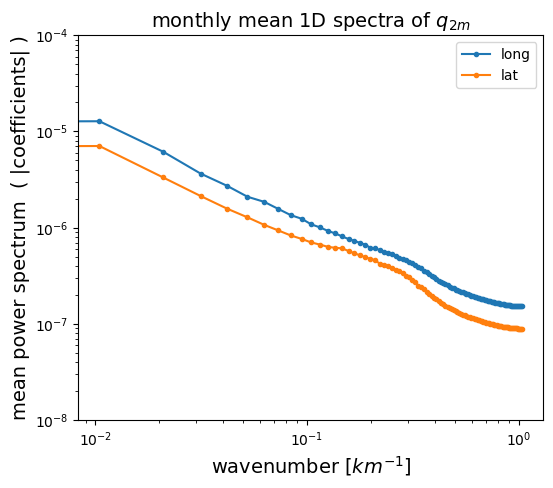

In [19]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

wvnmr, q2_month_lon, q2_month_lat = print_monthly_spectrum_1D(qa_spectr, title='$q_{2m}$', axis=ax, distance=False)
ax.set_ylim([10e-9, 10e-5])

### U

(1e-06, 0.1)

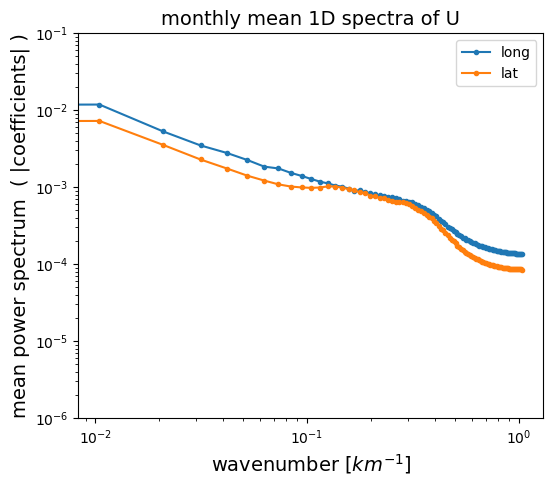

In [20]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

wvnmr, U_month_lon, U_month_lat = print_monthly_spectrum_1D(U_spectr, title='U', axis=ax, distance=False)
ax.set_ylim([10e-7, 10e-2])

### LHF

(0.001, 1.0)

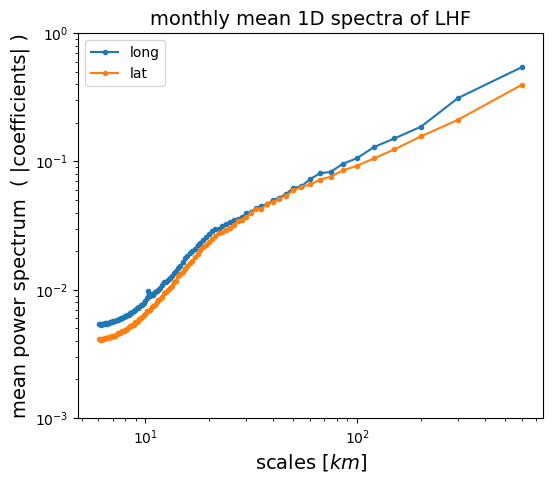

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

wvnmr, LHF_month_lon, LHF_month_lat = print_monthly_spectrum_1D(lhf_spectr, title='LHF', axis=ax, distance=True)
ax.set_ylim([10e-4, 10e-1])

### HFX

(0.0001, 0.1)

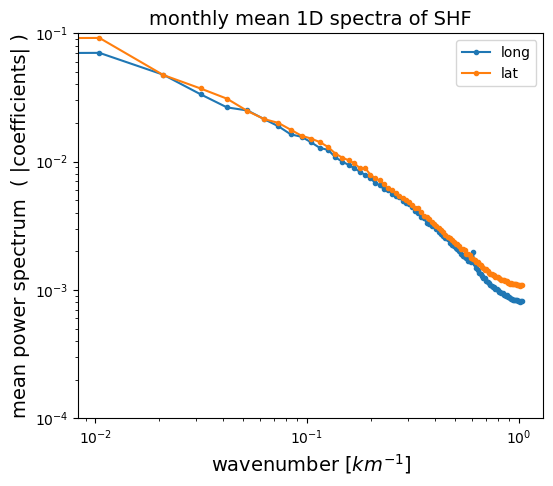

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

wvnmr, HFX_month_lon, HFX_month_lat = print_monthly_spectrum_1D(hfx_spectr, title='SHF', axis=ax, distance=False)
ax.set_ylim([10e-5, 10e-2])

## Computing spectra for anomalies now

In [23]:
sigma = 50
anomalies = {}
smooths = {}

for num, key in enumerate(full_fields):
    field = full_fields[key]
    field_sm, field_prime = np.zeros_like(field), np.zeros_like(field)
    
    for t in range(0,field.shape[0]):
        field_sm[t] = gm.nan_gaussian_filter(field[t], sigma)
        X_prime = field[t] - field_sm[t]
        field_prime[t] = gm.nan_gaussian_filter(X_prime,0)
    
    anomalies[key] = field_prime
    smooths[key] = field_sm

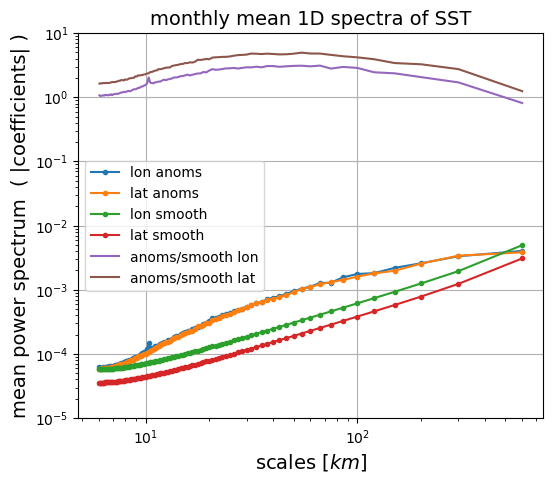

In [24]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

key = 'SST'

wvnmr, anoms_lon, anoms_lat   = print_monthly_spectrum_1D(anomalies[key], title=key, axis=ax, distance=True)
wvnmr, smooth_lon, smooth_lat = print_monthly_spectrum_1D(smooths[key], title=key, axis=ax, distance=True)

mean_anoms_lon, mean_anoms_lat = np.nanmean(anoms_lon, axis=(0,1)), np.nanmean(anoms_lat, axis=(0,1))
mean_smooth_lon, mean_smooth_lat = np.nanmean(smooth_lon, axis=(0,1)), np.nanmean(smooth_lat, axis=(0,1))


ax.plot(2*np.pi/wvnmr[:wvnmr.size//2], mean_anoms_lon[:mean_anoms_lon.size//2]/mean_smooth_lon[:mean_smooth_lon.size//2], label= 'anoms/smooth lon')
ax.plot(2*np.pi/wvnmr[:wvnmr.size//2], mean_anoms_lat[:mean_anoms_lat.size//2]/mean_smooth_lat[:mean_smooth_lat.size//2], label='anoms/smooth lat')
# ax.set_ylim([10e-10, 10e-2])
ax.legend(['lon anoms', 'lat anoms', 'lon smooth', 'lat smooth', 'anoms/smooth lon', 'anoms/smooth lat'], loc='center left')
ax.grid()

# Comparing with 2D Fourier spectra

In [25]:
## SLIGHTLY MODIFIED VERSIONS OF THE INITIAL 
## 1D FUNCTIONS THAT YOU CAN FIND ABOVE


def modified_spectrum_1D(y):
    import numpy as np    
    
    if y.ndim == 1:
        ################
        # multiplying by 3 because the gridpoints are each separated by 2km
        lengths_loc = 3*np.arange(0,len(y))
        ################

        fourier = np.fft.fft(y, norm='ortho')/((y.size))
        
        # multiply by 2\pi to obtain wavenumbers
        wvnmr = (2*np.pi)*np.fft.fftfreq(lengths_loc.size, d=np.diff(lengths_loc)[0])

        return wvnmr, np.abs(fourier)**2
    else:
        print('y seems not to be 1D, check!')


def print_modified_monthly_spectrum_1D(y, title, axis, distance=False):
    monthly_spectra_collector_lon = np.zeros((29, int(y[0,0].size), int(y[0,0].size)))
    monthly_spectra_collector_lat = np.zeros_like(monthly_spectra_collector_lon)
    wvnmr = np.zeros_like(monthly_spectra_collector_lon[0,0])

    for t in range(29):
        for i in range(y[t,0].size):
            yy = y[t, :, i] - np.nanmean(y[t, :, i])
            trash, monthly_spectra_collector_lon[t, i] = modified_spectrum_1D(yy)

            yy = y[t, i, :] - np.nanmean(y[t, i, :])
            trash, monthly_spectra_collector_lat[t, i] = modified_spectrum_1D(yy)

        if t == 1:
            # wvnmr are common for every spectrum, so I just save it once
            wvnmr = trash
            
    mean_monthly_spectrum_lon = np.mean(monthly_spectra_collector_lon, axis=(0,1))
    mean_monthly_spectrum_lat = np.mean(monthly_spectra_collector_lat, axis=(0,1))
    
    y_lon = mean_monthly_spectrum_lon[:mean_monthly_spectrum_lon.size//2]
    y_lat = mean_monthly_spectrum_lat[:mean_monthly_spectrum_lat.size//2]

    std_month_spectra_lon = np.std(monthly_spectra_collector_lon, axis=(0,1))   #/(np.sqrt(mean_spectrum.size))
    std_month_spectra_lat = np.std(monthly_spectra_collector_lat, axis=(0,1))   #/(np.sqrt(mean_spectrum.size))
    
    
    if distance:
        axis.loglog(2*np.pi/wvnmr[:wvnmr.size//2], y_lon, '.-', label='1D long')
        axis.loglog(2*np.pi/wvnmr[:wvnmr.size//2], y_lat, '.-', label='1D lat')
        axis.set_ylim([10e-6, 10e0])
        axis.set_xlabel(r'scales [$km$]', fontsize=14)
        
    else:
        axis.loglog(wvnmr[:wvnmr.size//2], y_lon, '.-', label='1D long')
        axis.loglog(wvnmr[:wvnmr.size//2], y_lat, '.-', label='1D lat')
        axis.set_ylim([10e-6, 10e0])
        axis.set_xlabel(r'wavenumber [$km^{-1}$]', fontsize=14)
    
#     axis.set_ylabel('', fontsize=14)
#     axis.set_title('monthly mean 1D spectra of '+title, fontsize=14)
    axis.legend()
    
    return wvnmr[:wvnmr.size//2], y_lon, y_lat

In [8]:
# MATTE'S FUNCTION
def Matte_power_spectrum_2d(c, dx, dy):
    # for the moment this func cannot deal with nan
    # c is input signal
    # dx is sampling rate along x
    # dy is sampling rate along y
    kx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(c.shape[1],dx))
    ky = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(c.shape[0],dy))
    ps2 = np.abs(np.fft.fft2(c-np.mean(c)))**2
    # shift to put freq 0 in the middle (positive freq up/right - negative freq bot/left)
    ps2 = np.fft.fftshift(ps2)        
    ps2 = ps2*(dx*dy)/(len(kx)*len(ky))

    kkx,kky = np.meshgrid(kx,ky)
    distance = np.sqrt(kkx**2+kky**2)
    kmax = min(kx[-1],ky[-1])
    dk = kx[1]-kx[0]
    kloop = np.arange(dk,kmax+dk,dk)
    ps2_iso = np.zeros(len(kloop))
    for ik,k in enumerate(kloop):
        id_k = (distance>k)&(distance<k+dk)
        ps2_iso[ik] = np.nanmean(ps2[id_k])
    return kloop,ps2_iso


# ALE'S FUNCTION
def ALE_power_spectrum_2d(c, dx, dy):
    # for the moment this func cannot deal with nan
    # c is input signal
    # dx is sampling rate along x
    # dy is sampling rate along y
    kx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(c.shape[1],dx))
    ky = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(c.shape[0],dy))
    ps2 = np.abs(np.fft.fft2(c-np.mean(c), norm='ortho'))**2
    
    # shift to put freq 0 in the middle (positive freq up/right - negative freq bot/left)
    ps2 = np.fft.fftshift(ps2)   
    
    # ONE SHOULD DIVIDE BY THE AREA, NOT MULTIPLY, RIGHT?
#     ps2 = ps2/((dx*dy)*(len(kx)*len(ky)))
    # SINCE NO DX DY ENTER THE NP.FFT FUNCTION, 
    # I GUESS ONE ONLY OUGHT TO USE NUMBER OF POINTS
    ps2 = ps2/(len(kx)*len(ky))

    kkx,kky = np.meshgrid(kx,ky)
    distance = np.sqrt(kkx**2+kky**2)
    kmax = min(kx[-1],ky[-1])
    dk = kx[1]-kx[0]
    kloop = np.arange(dk,kmax+dk,dk)
    ps2_iso = np.zeros(len(kloop))
    for ik,k in enumerate(kloop):
        id_k = (distance>k)&(distance<k+dk)
        ps2_iso[ik] = np.nanmean(ps2[id_k])
    return kloop,ps2_iso




# ALE'S FUNCTION with modifications found online
# from here: https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
def ALE_internet_power_spectrum_2d(c, dx, dy):
    import scipy.stats as stats
    
    # for the moment this func cannot deal with nan
    # c is input signal
    # dx is sampling rate along x
    # dy is sampling rate along y
    kx = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(c.shape[1],dx))
    ky = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(c.shape[0],dy))
    ps2 = np.abs(np.fft.fft2(c-np.mean(c), norm='ortho'))**2
    
    # shift to put freq 0 in the middle (positive freq up/right - negative freq bot/left)
    ps2 = np.fft.fftshift(ps2)   
    
    # ONE SHOULD DIVIDE BY THE AREA, NOT MULTIPLY, RIGHT?
#     ps2 = ps2/((dx*dy)*(len(kx)*len(ky)))
    # SINCE NO DX DY ENTER THE NP.FFT FUNCTION, 
    # I GUESS ONE ONLY OUGHT TO USE NUMBER OF POINTS
    ps2 = ps2/(len(kx)*len(ky))

    kkx,kky = np.meshgrid(kx,ky)
    distance = np.sqrt(kkx**2+kky**2)
    kmax = min(kx[-1],ky[-1])
    dk = kx[1]-kx[0]
    kloop = np.arange(dk,kmax+dk,dk)
    kvals = 0.5 * (kloop[1:] + kloop[:-1])
    
    Abins, _, _ = stats.binned_statistic(distance.flatten(), ps2.flatten(),
                                     statistic = "mean",
                                     bins = kloop)
    
    Abins *= np.pi * (kloop[1:]**2 - kloop[:-1]**2)
    
    return kvals, Abins


# OFFICIAL FUNCTION
def power_spectrum_2d(c, dx, dy):
    # for the moment this func cannot deal with nan
    # c is input signal
    # dx is sampling rate along x
    # dy is sampling rate along y
    kx = np.fft.fftshift(np.fft.fftfreq(c.shape[1],dx))
    ky = np.fft.fftshift(np.fft.fftfreq(c.shape[0],dy))
    ps2 = np.abs(np.fft.fft2(c-np.mean(c), norm='ortho'))**2
    
    # shift to put freq 0 in the middle (positive freq up/right - negative freq bot/left)
    ps2 = np.fft.fftshift(ps2)   
    
    ps2 = ps2/(len(kx)*len(ky))

    kkx,kky = np.meshgrid(kx,ky)
    distance = np.sqrt(kkx**2+kky**2)
    kmax = min(kx[-1],ky[-1])
    dk = kx[1]-kx[0]
    kloop = np.arange(dk,kmax+dk,dk)
    ps2_iso = np.zeros(len(kloop))
    
    for ik,k in enumerate(kloop):
        id_k = (distance>k)&(distance<k+dk)
        ps2_iso[ik] = np.nanmean(ps2[id_k])
    return kloop, ps2_iso

In [55]:
total_collector = {}

In [61]:
full_fields.keys()

dict_keys(['SST', 'T2', 'qsat', 'q2', 'U', 'LHF', 'HFX'])

In [9]:
dx, dy = 3, 3   # gridspace in km


key = 'HFX'
var = full_fields[key]

ntime = var.shape[0]
#########
for t in range(0,ntime):
    x = var[t]
    f,ps_i = power_spectrum_2d(x,dx,dy)
    if t == 0:
        ps_wrf_matte = np.zeros(len(ps_i))
    ps_wrf_matte = ps_wrf_matte + ps_i

mean_spectrum_matte = ps_wrf_matte/ntime
########
    
    
######################################################


# ps_wrf_ale = np.zeros((var.shape[0], var.shape[1]//2-1))
# wavenum = np.zeros(var.shape[1]//2-1)

# # dx, dy = 2, 2
# for t in range(0,var.shape[0]):
#     x = var[t]
#     wavenum,ps_i = ALE_power_spectrum_2d(x,dx,dy)
    
#     ps_wrf_ale[t] = ps_i

# mean_spectrum_ale = np.nanmean(ps_wrf_ale, axis=0)

# ########################################################

# # dx, dy = 2, 2
# for t in range(0,ntime):
#     x = var[t]
#     k, binned_values = ALE_internet_power_spectrum_2d(x, dx, dy)
#     if t == 0:
#         ps_wrf_internet = np.zeros(len(binned_values))
#     ps_wrf_internet = ps_wrf_internet + binned_values

# mean_spectrum_internet = ps_wrf_internet/ntime





NameError: name 'full_fields' is not defined

In [ ]:
##############    plotting    ##############

fig, ax = plt.subplots(1,1)
ax.grid()

## my 1D thing
wavenum_1D, spectr_lon, spectr_lat = print_modified_monthly_spectrum_1D(var, title='', axis=ax, distance=False)

ax.loglog(f,       mean_spectrum_matte, label='matte original')
# ax.loglog(wavenum, mean_spectrum_ale, label='matte ale modified')
# ax.loglog(k,       mean_spectrum_internet, label='ale internet modified')


ax.legend(loc='upper right')
ax.set_ylim([10e-10, 10e2])

ax.set_title('Comparing PS methods above for '+key+' forced',  fontsize=14)
ax.set_ylabel(r'$|coeff|^2$',  fontsize=14)
ax.set_xlabel(r'wavenumber [$km^{-1}$]', fontsize=14)

In [87]:
all_spectra = {
    'description': key+' squared Fourier coefficients, only positive frequencies',
    'matte original': [f, mean_spectrum_matte],
    'matte ale modified': [wavenum, mean_spectrum_ale],
    'ale internet modified': [k, mean_spectrum_internet], 
    '1D lon': [wavenum_1D, spectr_lon], 
    '1D lat': [wavenum_1D, spectr_lat]
}

total_collector[key] = all_spectra

In [88]:
total_collector.keys()

dict_keys(['SST', 'T2', 'qsat', 'q2', 'U', 'LHF', 'HFX'])

In [99]:
import pickle 

with open('/venus/tesi_ale/data_EU/Fourier_spectra/forced/forced_fullFields_spectra_dict.pkl', 'wb') as f:
    pickle.dump(total_collector, f)

In [100]:
'''with open('/venus/tesi_ale/data_EU/Fourier_spectra/forced/forced_fullFields_spectra_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)'''

# Comparing FORCED spectra with COUPLED

In [29]:
import pickle

coupled_path = '/venus/tesi_ale/data_EU/Fourier_spectra/coupled/coupled_fullFields_spectra_dict.pkl'
forced_path = '/venus/tesi_ale/data_EU/Fourier_spectra/forced/forced_fullFields_spectra_dict.pkl'

with open(coupled_path, 'rb') as f:
    coupled_dict = pickle.load(f)
    
with open(forced_path, 'rb') as f:
    forced_dict = pickle.load(f)

In [30]:
coupled_dict['SST']['description']

'SST squared Fourier coefficients, only positive frequencies'

#### computing little bit of a regression line

In [10]:
linreg_small_coupled.slope

-2.862226291492349

forced small = -2.1342925054922848
forced large = -3.8901968043897934
coupled small = -2.8112890658602776
coupled large = -2.722575686680549


Text(0.6000000000000001, 0.0001, '$k^{-2.8}$')

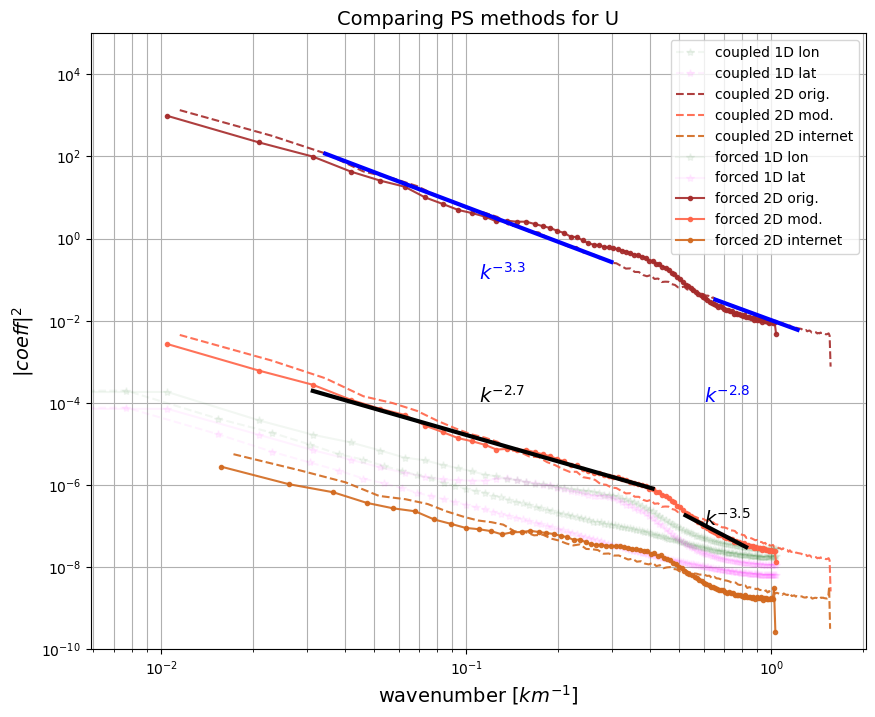

In [40]:
key_plot = 'U'

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.grid(which='both')

cols = ['brown', 'tomato', 'chocolate', 'darkgreen', 'magenta']

alpha_1D = 0.05
alpha_2D = 0.9

distances = False

############  coupled  ##############
x_1D = coupled_dict[key_plot]['1D lon'][0] if not distances else 2*np.pi/coupled_dict[key_plot]['1D lon'][0]
x_mO = coupled_dict[key_plot]['matte original'][0] if not distances else 2*np.pi/coupled_dict[key_plot]['matte original'][0]
x_aM = coupled_dict[key_plot]['matte ale modified'][0] if not distances else 2*np.pi/coupled_dict[key_plot]['matte ale modified'][0]
x_aI = coupled_dict[key_plot]['ale internet modified'][0] if not distances else 2*np.pi/coupled_dict[key_plot]['ale internet modified'][0]


# alpha_cou = 0.5
ax.loglog(x_1D, coupled_dict[key_plot]['1D lon'][1], '*--', color=cols[3], alpha=alpha_1D, label='coupled 1D lon')
ax.loglog(x_1D, coupled_dict[key_plot]['1D lat'][1], '*--', color=cols[4], alpha=alpha_1D, label='coupled 1D lat')
ax.loglog(x_mO, coupled_dict[key_plot]['matte original'][1], '--', color=cols[0], alpha=alpha_2D, label='coupled 2D orig.')
ax.loglog(x_aM, coupled_dict[key_plot]['matte ale modified'][1], '--', color=cols[1], alpha=alpha_2D, label='coupled 2D mod.')
ax.loglog(x_aI, coupled_dict[key_plot]['ale internet modified'][1], '--', color=cols[2], alpha=alpha_2D, label='coupled 2D internet')





#############  forced  ###################
x_1D = forced_dict[key_plot]['1D lon'][0] if not distances else 2*np.pi/forced_dict[key_plot]['1D lon'][0]
x_mO = forced_dict[key_plot]['matte original'][0] if not distances else 2*np.pi/forced_dict[key_plot]['matte original'][0]
x_aM = forced_dict[key_plot]['matte ale modified'][0] if not distances else 2*np.pi/forced_dict[key_plot]['matte ale modified'][0]
x_aI = forced_dict[key_plot]['ale internet modified'][0] if not distances else 2*np.pi/forced_dict[key_plot]['ale internet modified'][0]


# alpha_ff = 1
ax.loglog(x_1D, forced_dict[key_plot]['1D lon'][1], '*-', color=cols[3], alpha=alpha_1D, label='forced 1D lon')
ax.loglog(x_1D, forced_dict[key_plot]['1D lat'][1], '*-', color=cols[4], alpha=alpha_1D, label='forced 1D lat')
ax.loglog(x_mO, forced_dict[key_plot]['matte original'][1], '.-', color=cols[0], alpha=alpha_2D, label='forced 2D orig.')
ax.loglog(x_aM, forced_dict[key_plot]['matte ale modified'][1], '.-', color=cols[1], alpha=alpha_2D, label='forced 2D mod.')
ax.loglog(x_aI, forced_dict[key_plot]['ale internet modified'][1], '.-', color=cols[2], alpha=alpha_2D, label='forced 2D internet')


ax.legend(loc='upper right')

ax.set_title('Comparing PS methods for '+key_plot,  fontsize=14)
ax.set_ylabel(r'$|coeff|^2$',  fontsize=14)

xlab = r'wavenumber [$km^{-1}$]' if not distances else r'scale [$km$]'
ax.set_xlabel(xlab, fontsize=14)

ax.set_ylim([10e-11, 10e4])






###########  slopes for comparison  #############

###  forced  ###

k_small_forced = np.log10(forced_dict[key_plot]['matte ale modified'][0][2:-60] )
spectr_small_forced = np.log10(forced_dict[key_plot]['matte ale modified'][1][2:-60])
linreg_small_forced, corr_small_forced, p_small_forced, chi_square = slopes_r_p(x=k_small_forced, y=spectr_small_forced, std_y=None)
print(f'forced small = {linreg_small_forced.slope}')


k_large_forced = np.log10(forced_dict[key_plot]['matte ale modified'][0][-50:-20] )
spectr_large_forced = np.log10(forced_dict[key_plot]['matte ale modified'][1][-50:-20])
linreg_large_forced, corr_large_forced, p_large_forced, chi_square = slopes_r_p(x=k_large_forced, y=spectr_large_forced, std_y=None)
print(f'forced large = {linreg_large_forced.slope}')



xx = forced_dict[key_plot]['matte ale modified'][0]
# line_2 = (xx[2:-60])**(-2)
# line_4 = (xx[-50:-20])**(-4)

line_small_forced = (10**linreg_small_forced.intercept)*(xx[2:-60])**(linreg_small_forced.slope)
line_large_forced = (10**linreg_large_forced.intercept)*(xx[-50:-20])**(linreg_large_forced.slope)

ax.loglog(xx[2:-60], line_small_forced, 'k', linewidth=3, label=r'$k^{-2.5}$')
ax.loglog(xx[-50:-20], line_large_forced, 'k', linewidth=3, label=r'$k^{-3.9}$')

ax.text(1.1*10e-2, 10e-5, r'$k^{-2.7}$', fontsize=14)
ax.text(6*10e-2, 10e-8, r'$k^{-3.5}$', fontsize=14)




###  coupled  ###
k_small_coupled = np.log10(coupled_dict[key_plot]['matte original'][0][2:-110] )
spectr_small_coupled = np.log10(coupled_dict[key_plot]['matte original'][1][2:-110])
linreg_small_coupled, corr_small_coupled, p_small_coupled, chi_square = slopes_r_p(x=k_small_coupled, y=spectr_small_coupled, std_y=None)
print(f'coupled small = {linreg_small_coupled.slope}')

k_large_coupled = np.log10(coupled_dict[key_plot]['matte original'][0][-90:-30] )
spectr_large_coupled = np.log10(coupled_dict[key_plot]['matte original'][1][-90:-30])
linreg_large_coupled, corr_large_coupled, p_large_coupled, chi_square = slopes_r_p(x=k_large_coupled, y=spectr_large_coupled, std_y=None)
print(f'coupled large = {linreg_large_coupled.slope}')

xx = coupled_dict[key_plot]['matte original'][0]

line_small_coupled = (10**linreg_small_coupled.intercept)*(xx[2:-110])**(linreg_small_coupled.slope)
line_large_coupled = (10**linreg_large_coupled.intercept)*(xx[-80:-30])**(linreg_large_coupled.slope)

ax.loglog(xx[2:-110], line_small_coupled, 'k', linewidth=3, label=r'$k^{-2.86}$', color='b')
ax.loglog(xx[-80:-30], line_large_coupled, 'k', linewidth=3, label=r'$k^{-3.9}$', color='b')

ax.text(1.1*10e-2, 10e-2, r'$k^{-3.3}$', fontsize=14, color='b')
ax.text(6*10e-2, 10e-5, r'$k^{-2.8}$', fontsize=14, color='b')


# k_small_forced = np.log10(forced_dict[key_plot]['matte ale modified'][0][2:-60] )
# spectr_small_forced = np.log10(forced_dict[key_plot]['matte ale modified'][1][2:-60])
# linreg_small_forced, corr_small_forced, p_small_forced, chi_square = slopes_r_p(x=k_small_forced, y=spectr_small_forced, std_y=None)
# print(f'forced small = {linreg_small_forced.slope}')


# k_large_forced = np.log10(forced_dict[key_plot]['matte ale modified'][0][-50:-20] )
# spectr_large_forced = np.log10(forced_dict[key_plot]['matte ale modified'][1][-50:-20])
# linreg_large_forced, corr_large_forced, p_large_forced, chi_square = slopes_r_p(x=k_large_forced, y=spectr_large_forced, std_y=None)
# print(f'forced large = {linreg_large_forced.slope}')



# xx = forced_dict[key_plot]['matte ale modified'][0]
# # line_2 = (xx[2:-60])**(-2)
# # line_4 = (xx[-50:-20])**(-4)

# line_small_forced = (10**linreg_small_forced.intercept)*(xx[2:-60])**(linreg_small_forced.slope)
# line_large_forced = (10**linreg_large_forced.intercept)*(xx[-50:-20])**(linreg_large_forced.slope)

# ax.loglog(xx[2:-60], line_small_forced, 'k', linewidth=3, label=r'$k^{-2.5}$')
# ax.loglog(xx[-50:-20], line_large_forced, 'k', linewidth=3, label=r'$k^{-3.9}$')

# ax.text(1.1*10e-2, 10e-5, r'$k^{-2.7}$', fontsize=14)
# ax.text(6*10e-2, 10e-8, r'$k^{-3.5}$', fontsize=14)




###  coupled  ###
# k_small_coupled = np.log10(coupled_dict[key_plot]['matte original'][0][2:-110] )
# spectr_small_coupled = np.log10(coupled_dict[key_plot]['matte original'][1][2:-110])
# linreg_small_coupled, corr_small_coupled, p_small_coupled, chi_square = slopes_r_p(x=k_small_coupled, y=spectr_small_coupled, std_y=None)
# print(f'coupled small = {linreg_small_coupled.slope}')

# k_large_coupled = np.log10(coupled_dict[key_plot]['matte original'][0][-90:-30] )
# spectr_large_coupled = np.log10(coupled_dict[key_plot]['matte original'][1][-90:-30])
# linreg_large_coupled, corr_large_coupled, p_large_coupled, chi_square = slopes_r_p(x=k_large_coupled, y=spectr_large_coupled, std_y=None)
# print(f'coupled large = {linreg_large_coupled.slope}')

# xx = coupled_dict[key_plot]['matte original'][0]

# line_small_coupled = (10**linreg_small_coupled.intercept)*(xx[2:-110])**(linreg_small_coupled.slope)
# line_large_coupled = (10**linreg_large_coupled.intercept)*(xx[-80:-30])**(linreg_large_coupled.slope)

# ax.loglog(xx[2:-110], line_small_coupled, 'k', linewidth=3, label=r'$k^{-2.86}$', color='b')
# ax.loglog(xx[-80:-30], line_large_coupled, 'k', linewidth=3, label=r'$k^{-3.9}$', color='b')

# ax.text(1.1*10e-2, 10e-2, r'$k^{-3.3}$', fontsize=14, color='b')
# ax.text(6*10e-2, 10e-5, r'$k^{-2.8}$', fontsize=14, color='b')


# ax.set_xlim([0.1, 1])

Text(0.5, 0, 'wavenumber [$km^{-1}$]')

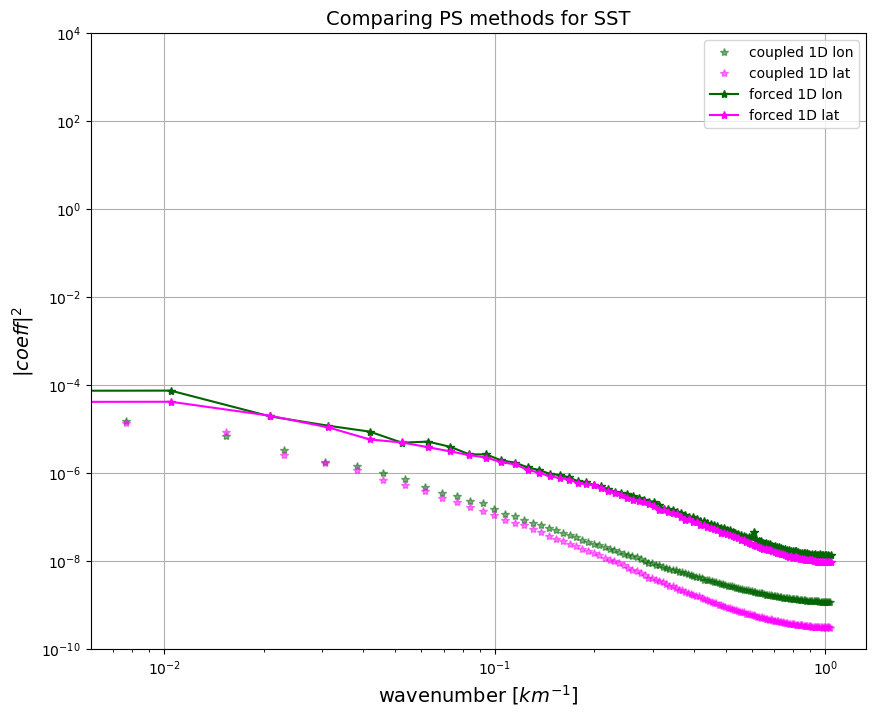

In [124]:
key_plot = 'SST'

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.grid()

cols = ['brown', 'tomato', 'chocolate', 'darkgreen', 'magenta']

do_1D_only = True

############  coupled  ##############
alpha_cou = 0.5
if do_1D_only:
    ax.loglog(coupled_dict[key_plot]['1D lon'][0], coupled_dict[key_plot]['1D lon'][1], '*', color=cols[3], alpha=alpha_cou, label='coupled 1D lon')
    ax.loglog(coupled_dict[key_plot]['1D lat'][0], coupled_dict[key_plot]['1D lat'][1], '*', color=cols[4], alpha=alpha_cou, label='coupled 1D lat')
else:
    ax.loglog(coupled_dict[key_plot]['matte original'][0], coupled_dict[key_plot]['matte original'][1], '--', color=cols[0], alpha=alpha_cou, label='coupled 2D orig.')
    ax.loglog(coupled_dict[key_plot]['matte ale modified'][0], coupled_dict[key_plot]['matte ale modified'][1], '--', color=cols[1], alpha=alpha_cou, label='coupled 2D mod.')
    ax.loglog(coupled_dict[key_plot]['ale internet modified'][0], coupled_dict[key_plot]['ale internet modified'][1], '--', color=cols[2], alpha=alpha_cou, label='coupled 2D internet')





#############  forced  ###################
alpha_ff = 1
if do_1D_only:
    ax.loglog(forced_dict[key_plot]['1D lon'][0], forced_dict[key_plot]['1D lon'][1], '*-', color=cols[3], alpha=alpha_ff, label='forced 1D lon')
    ax.loglog(forced_dict[key_plot]['1D lat'][0], forced_dict[key_plot]['1D lat'][1], '*-', color=cols[4], alpha=alpha_ff, label='forced 1D lat')
else:
    ax.loglog(forced_dict[key_plot]['matte original'][0], forced_dict[key_plot]['matte original'][1], '.-', color=cols[0], alpha=alpha_ff, label='forced 2D orig.')
    ax.loglog(forced_dict[key_plot]['matte ale modified'][0], forced_dict[key_plot]['matte ale modified'][1], '.-', color=cols[1], alpha=alpha_ff, label='forced 2D mod.')
    ax.loglog(forced_dict[key_plot]['ale internet modified'][0], forced_dict[key_plot]['ale internet modified'][1], '.-', color=cols[2], alpha=alpha_ff, label='forced 2D internet')


ax.legend(loc='upper right')
ax.set_ylim([10e-11, 10e3])

ax.set_title('Comparing PS methods for '+key_plot,  fontsize=14)
ax.set_ylabel(r'$|coeff|^2$',  fontsize=14)
ax.set_xlabel(r'wavenumber [$km^{-1}$]', fontsize=14)



## Test of 1D over a known 2D signal

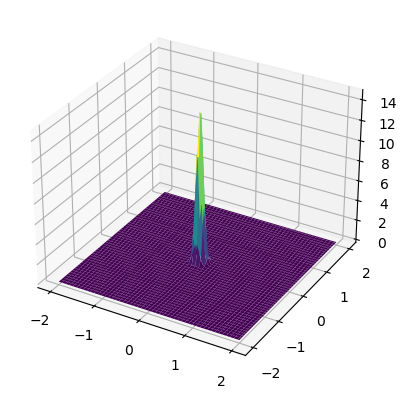

In [32]:
x, y = np.linspace(-2, 2, 100), np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x,y)

sigma = 0.1
Z = (1/(2*np.pi*sigma**2))*np.exp(-(X**2+Y**2)/sigma**2)

fig, ax = plt.subplots(1,1, subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z, cmap='viridis')


In [33]:
def local_spectrum_1D(y):
    import numpy as np    
    
    if y.ndim == 1:
        ################
        # multiplying by 2 because the gridpoints are each separated by 2km
        lengths_loc = np.arange(0,len(y))
        ################

        fourier = np.fft.fft(y, norm='ortho')/(2*(y.size-1))
        
        # multiply by 2\pi to obtain wavenumbers
        wvnmr = (2*np.pi)*np.fft.fftfreq(lengths_loc.size, d=np.diff(lengths_loc)[0])

        return wvnmr, np.abs(fourier)
    else:
        print('y seems not to be 1D, check!')

spectr = np.zeros_like(X)
wavenum = np.zeros_like(x)
        
for j in range(y.size):
    signal = Z[:,j]
    trash, spectr[j,:] = local_spectrum_1D(signal)
    if j == 0:
        wavenum = trash
        
#     plt.plot(wavenum, spectr[:,j], '*' )
        
# plt.plot(wavenum, np.sum(spectr, axis=0), '*' )





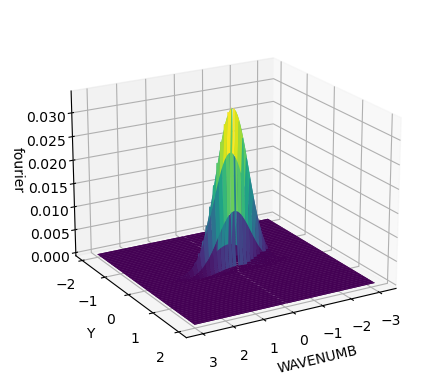

In [38]:
fig, ax = plt.subplots(1,1, subplot_kw={"projection": "3d"})
ax.plot_surface(wavenum, Y, spectr, cmap='viridis')
ax.set_xlabel('WAVENUMB')
ax.set_ylabel('Y')
ax.set_zlabel('fourier')

ax.view_init(20,60)

# 1D spectra over longitude / latitude

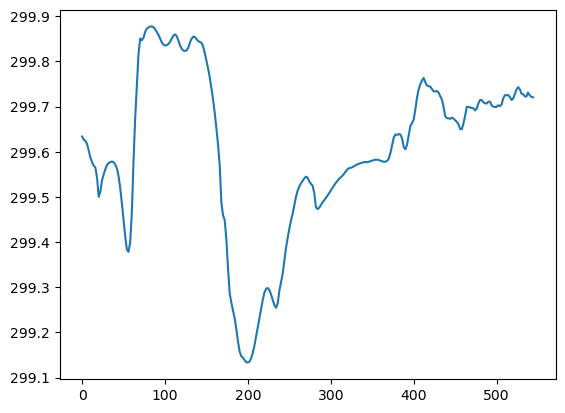

In [47]:
sst_1d = sst_day[0, :, 210]
lengths = 2*np.arange(0,len(sst_1d))
plt.plot(lengths, sst_1d)

Text(0.5, 1.0, '1D spectrum of SST anomalies at given longitude')

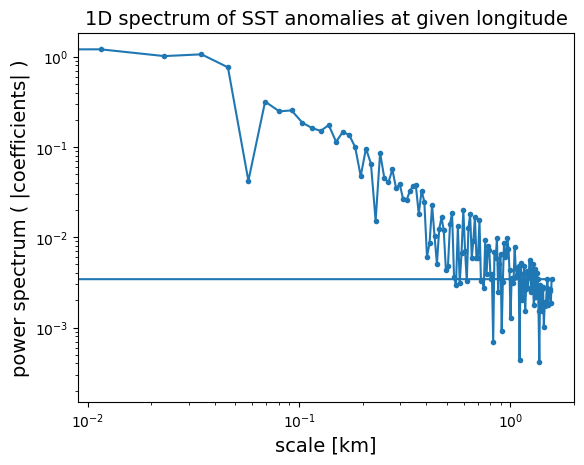

In [55]:
fourier = np.fft.fft(sst_1d-np.mean(sst_1d), norm='ortho')
freq = 2*np.pi*np.fft.fftfreq(lengths.size, d=np.diff(lengths)[0])
# freq_shift = np.fft.fftshift(freq)

strength = np.abs(fourier)

plt.loglog(freq[:freq.size//2], strength[:strength.size//2], '.-')
plt.xlabel('scale [km]', fontsize=14)
plt.ylabel('power spectrum ( |coefficients| )', fontsize=14)
plt.title('1D spectrum of SST anomalies at given longitude', fontsize=14)





## instantaneous

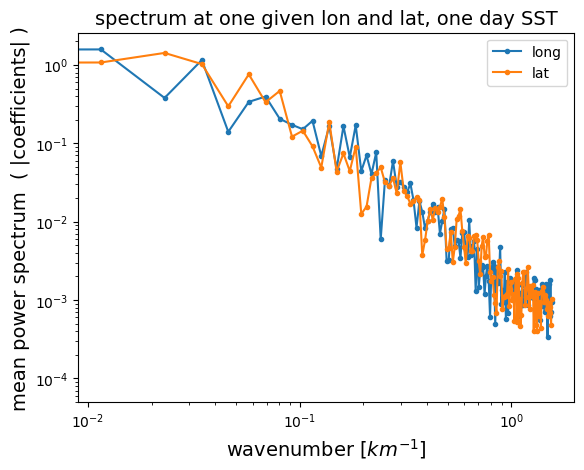

In [24]:
lon_level, lat_level = 50, 100
yy = sst_day[0, :, lon_level] - np.nanmean(sst_day[0, :, lon_level])
trash, spectra_lon = special_spectrum_1D(yy)

yy = sst_day[0, lat_level, :] - np.nanmean(sst_day[0, lat_level, :])
trash, spectra_lat = special_spectrum_1D(yy)


plt.loglog(wvnmr[:wvnmr.size//2], spectra_lon[:spectra_lon.size//2], '.-', label='long')
plt.loglog(wvnmr[:wvnmr.size//2], spectra_lat[:spectra_lat.size//2], '.-', label='lat')

plt.xlabel(r'wavenumber [$km^{-1}$]', fontsize=14)
plt.ylabel('mean power spectrum  ( |coefficients| )', fontsize=14)
plt.title('spectrum at one given lon and lat, one day SST', fontsize=14)
plt.legend()

### mean of 1 day

In [32]:
spectra_collector_lon = np.zeros((int(sst_day[0,0].size), int(sst_day[0,0].size)))
spectra_collector_lat = np.zeros_like(spectra_collector_lon)
wvnmr = np.zeros_like(spectra_collector_lon[0])

for i in range(sst_day[0,0].size):
    yy = sst_day[10, :, i] - np.nanmean(sst_day[10, :, i])
    trash, spectra_collector_lon[i] = special_spectrum_1D(yy)
    
    yy = sst_day[10, i, :] - np.nanmean(sst_day[10, i, :])
    trash, spectra_collector_lat[i] = special_spectrum_1D(yy)
    
    if i == 1:
        # wvnmr are common for every spectrum, so I just save it once
        wvnmr = trash

In [31]:
spectra_collector_lon.shape

(273, 273)

In [87]:
wvnmr.shape

(273,)

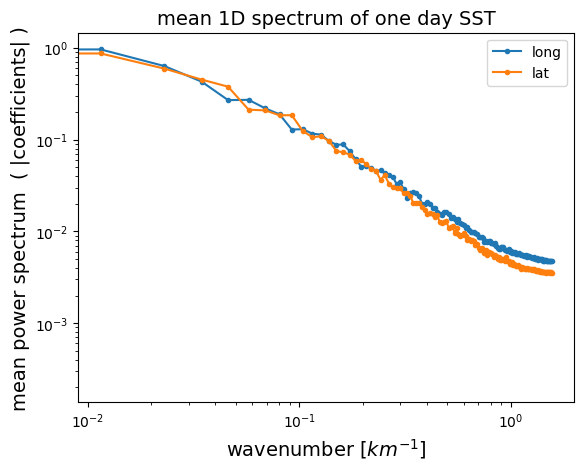

In [34]:
mean_spectrum_lon = np.mean(spectra_collector_lon, axis=0)
std_spectra_lon = np.std(spectra_collector_lon, axis=1)/(np.sqrt(mean_spectrum_lon.size))

mean_spectrum_lat = np.mean(spectra_collector_lat, axis=0)
std_spectra_lat = np.std(spectra_collector_lat, axis=1)/(np.sqrt(mean_spectrum_lat.size))

# plt.errorbar(wvnmr[:wvnmr.size//2], mean_spectrum_lon[:mean_spectrum_lon.size//2], yerr=std_spectra_lon[:std_spectra_lon.size//2], label='long')
# plt.errorbar(wvnmr[:wvnmr.size//2], mean_spectrum_lat[:mean_spectrum_lat.size//2], yerr=std_spectra_lat[:std_spectra_lat.size//2], label='lat')

plt.loglog(wvnmr[:wvnmr.size//2], mean_spectrum_lon[:mean_spectrum_lon.size//2], '.-', label='long')
plt.loglog(wvnmr[:wvnmr.size//2], mean_spectrum_lat[:mean_spectrum_lat.size//2], '.-', label='lat')

plt.xlabel(r'wavenumber [$km^{-1}$]', fontsize=14)
plt.ylabel('mean power spectrum  ( |coefficients| )', fontsize=14)
plt.title('mean 1D spectrum of one day SST', fontsize=14)
plt.legend()

### monthly mean of spectra

In [28]:
monthly_spectra_collector_lon = np.zeros((29, int(sst_day[0,0].size), int(sst_day[0,0].size)))
monthly_spectra_collector_lat = np.zeros_like(monthly_spectra_collector_lon)
wvnmr = np.zeros_like(monthly_spectra_collector_lon[0,0])

for t in range(29):
    for i in range(sst_day[t,0].size):
        yy = sst_day[t, :, i] - np.nanmean(sst_day[t, :, i])
        trash, monthly_spectra_collector_lon[t, i] = special_spectrum_1D(yy)
        
        yy = sst_day[t, i, :] - np.nanmean(sst_day[t, i, :])
        trash, monthly_spectra_collector_lat[t, i] = special_spectrum_1D(yy)
        
    if t == 1:
        # wvnmr are common for every spectrum, so I just save it once
        wvnmr = trash

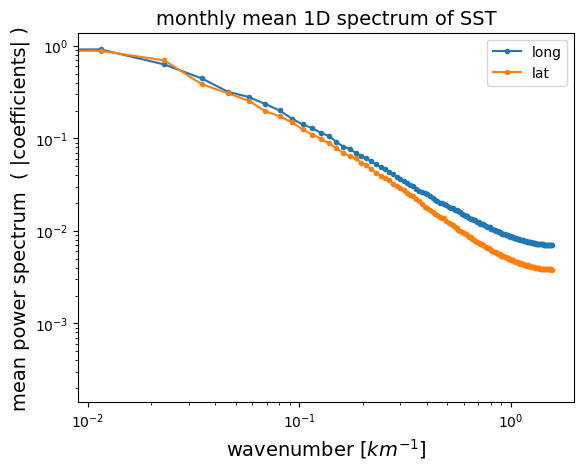

In [29]:
mean_monthly_spectrum_lon = np.mean(monthly_spectra_collector_lon, axis=(0,1))
mean_monthly_spectrum_lat = np.mean(monthly_spectra_collector_lat, axis=(0,1))

std_month_spectra_lon = np.std(monthly_spectra_collector_lon, axis=(0,1))   #/(np.sqrt(mean_spectrum.size))
std_month_spectra_lat = np.std(monthly_spectra_collector_lat, axis=(0,1))   #/(np.sqrt(mean_spectrum.size))


# plt.errorbar(wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lon[:mean_monthly_spectrum_lon.size//2], yerr=std_month_spectra_lon[:std_month_spectra_lon.size//2])
# plt.errorbar(wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lat[:mean_monthly_spectrum_lat.size//2], yerr=std_month_spectra_lat[:std_month_spectra_lat.size//2])

plt.loglog(wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lon[:mean_monthly_spectrum_lon.size//2], '.-', label='long')
plt.loglog(wvnmr[:wvnmr.size//2], mean_monthly_spectrum_lat[:mean_monthly_spectrum_lat.size//2], '.-', label='lat')

plt.xlabel(r'wavenumber [$km^{-1}$]', fontsize=14)
plt.ylabel('mean power spectrum  ( |coefficients| )', fontsize=14)
plt.title('monthly mean 1D spectra of SST', fontsize=14)
plt.legend()

## testing my function for plotting fourier spectra averaged over the whole month

In [24]:
type(sst_spectr)

numpy.ndarray

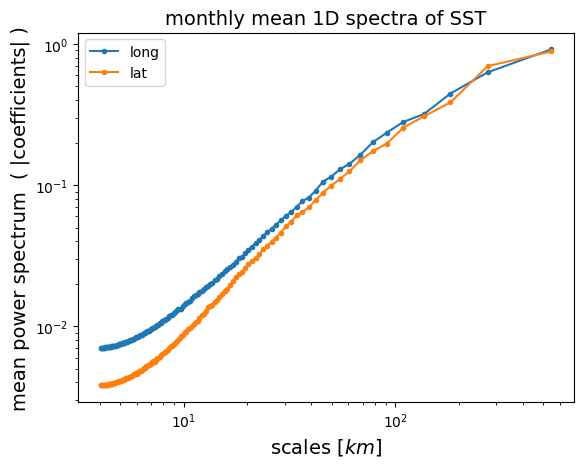

In [26]:
y = sst_spectr
title = 'SST'
print_monthly_spectrum_1D(y, title, distance=True)

# 2D case - A very dirty try

In [10]:
dsst_spectr = np.fft.fft2(dsst_day[0], norm='ortho')
dsst_spectr_ampl = np.abs(dsst_spectr)
dsst_spectr_phase = np.angle(dsst_spectr)

# shift the zero-frequency component at the centre of the spectrum
dsst_spectr_centred = np.fft.fftshift(dsst_spectr)
dsst_spectr_centr_ampl = np.abs(dsst_spectr_centred)
dsst_spectr_centr_phase = np.angle(dsst_spectr_centred)

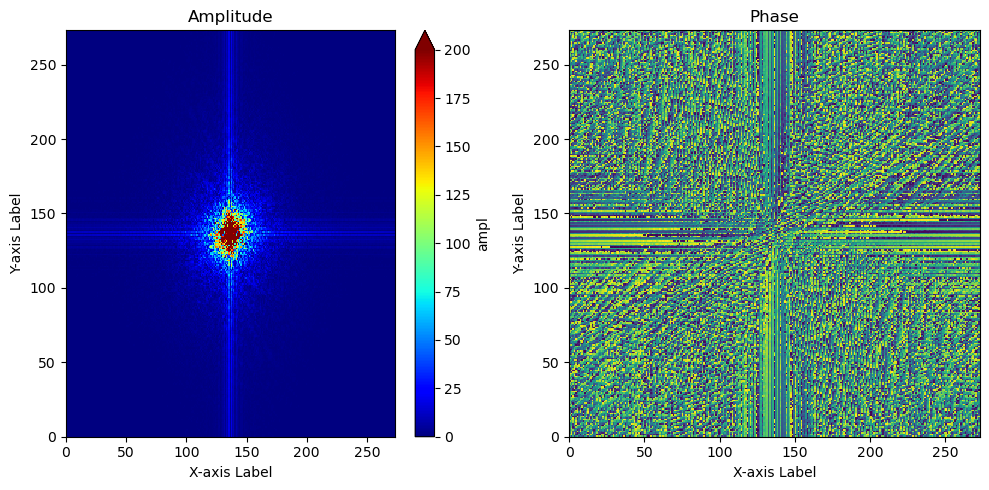

In [11]:

# Create a figure and 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First subplot (left)
im = axes[0].pcolormesh(dsst_spectr_centr_ampl, vmin=0, vmax=200, cmap='jet')
cbar = plt.colorbar(im, ax=axes[0], extend='max')
cbar.set_label('ampl')

axes[0].set_title('Amplitude')
axes[0].set_xlabel('X-axis Label')
axes[0].set_ylabel('Y-axis Label')

# Second subplot (right)
axes[1].pcolormesh(dsst_spectr_centr_phase)
axes[1].set_title('Phase')
axes[1].set_xlabel('X-axis Label')
axes[1].set_ylabel('Y-axis Label')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
npix = len(dsst_day[0].flatten())
npix

74529

https://stackoverflow.com/questions/66977714/generating-new-2d-data-using-power-spectrum-density-function-from-spatial-freque

https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/

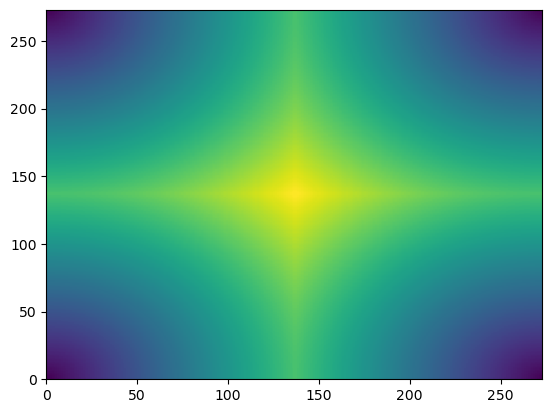

In [70]:
plt.pcolormesh(knrm_mesh)

In [74]:
npix

273

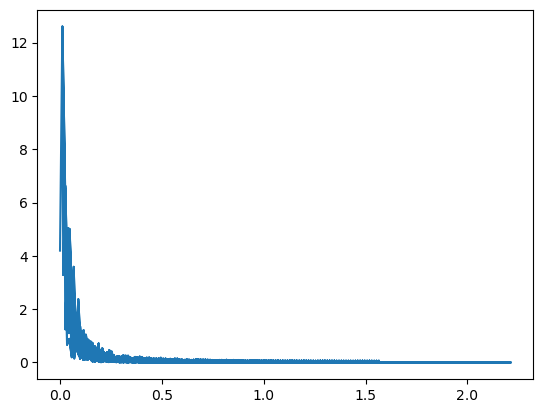

In [76]:
fourier_image = np.fft.fft2(dsst_day[0], norm='ortho')
#fourier_image = np.fft.fftshift(fourier_image)
fourier_amplitudes = np.abs(fourier_image)

npix = len(dsst_day[0])

kfreq = 2*np.pi*np.fft.fftfreq(npix, d=2000)  # *npix   # 2 km
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm_mesh = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()


kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= (kbins[1:]**2 - kbins[:-1]**2)

plt.plot(Abins)


plt.plot(knrm, fourier_amplitudes)
plt.show()

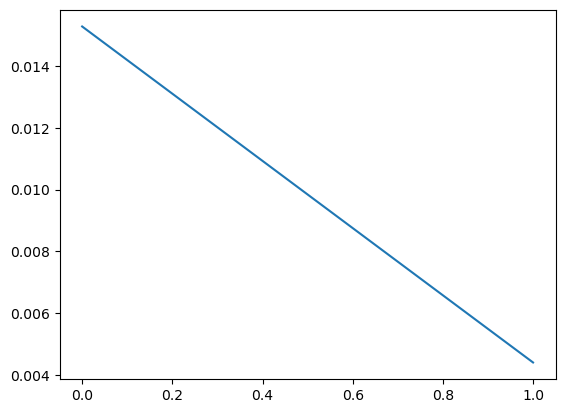

In [77]:
kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= (kbins[1:]**2 - kbins[:-1]**2)

plt.plot(Abins)

# try another approach: first do the fft along y, and then x

In [109]:
fourier_lat = np.fft.fft(sst_day[0], axis=0, norm='ortho')
wvnmr_lat = 2*np.pi*np.fft.fftfreq(sst_day[0,:,0].size, d=2)
fourier_lat = fourier_lat.reshape(273,273)

In [110]:
fourier_lat_lon = np.fft.fft(fourier_lat, axis=1, norm='ortho')
wvnmr_lon = wvnmr_lat

In [114]:
wvnmr_lon, wvnmr_lat = np.meshgrid(wvnmr_lon, wvnmr_lat)
wvnmr = np.sqrt(wvnmr_lon**2+wvnmr_lat**2)

In [115]:
strength = np.abs(fourier_lat_lon)

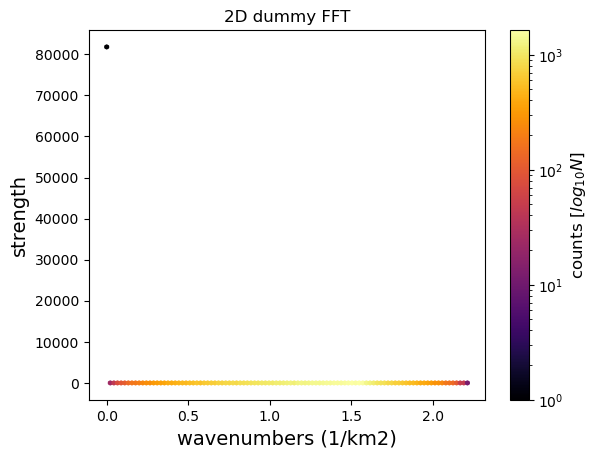

In [117]:
title = '2D dummy FFT'
xlabel = 'wavenumbers (1/km)'
ylabel = 'strength'

pos = [0.9, 0.9]

density_hexbin(wvnmr, strength, plot_fit = False, fit=None, corcoe=None, grdsz=100, title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos)


# NO

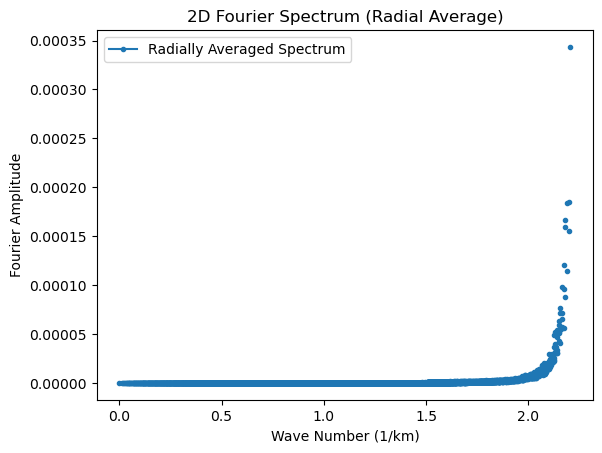

In [87]:
## CORRETTO DA CHATGPT, INFATTI NON FUNZIONA


import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Perform 2D Fourier transform of the image with normalization
fourier_image = np.fft.fft2(dsst_day[0], norm='ortho')
fourier_image = np.fft.fftshift(fourier_image)  # Shift zero frequency component to center
fourier_amplitudes = np.abs(fourier_image)

# Define the number of pixels in one dimension of the image
npix = dsst_day[0].shape[0]

# Define the frequency array based on spatial resolution (2 km in this case)
kfreq = np.fft.fftfreq(npix, d=2)  # 2 km per pixel spatial resolution
kfreq = 2 * np.pi * kfreq  # Convert to angular frequency (radians per km)

# Create 2D frequency grid
kfreq_x, kfreq_y = np.meshgrid(kfreq, kfreq)
knrm_mesh = np.sqrt(kfreq_x**2 + kfreq_y**2)

# Flatten the arrays for binning
knrm = knrm_mesh.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

# Define the radial bins for averaging
kbins = np.arange(0.0, knrm.max(), 2 * np.pi / (npix * 2000))  # set bin width for radial averaging
kvals = 0.5 * (kbins[1:] + kbins[:-1])

# Calculate the mean Fourier amplitude in each radial bin
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic="mean",
                                     bins=kbins)

# Adjust for bin area by scaling with radial shell width (if needed for amplitude adjustment)
Abins *= (kbins[1:]**2 - kbins[:-1]**2)

# Plot the radially averaged Fourier spectrum
plt.plot(kvals, Abins, '.-', label="Radially Averaged Spectrum")
plt.xlabel("Wave Number (1/km)")
plt.ylabel("Fourier Amplitude")
plt.title("2D Fourier Spectrum (Radial Average)")
plt.legend()
plt.show()
